In [1]:
!pip install torch torchvision tqdm


In [2]:
!pip install ultralytics==8.2.20 opencv-python


   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---------------------------------------- 0.0/760.3 kB ? eta -:--:--
   ---

TRAIN THE CLASSIFIER ON  DATASET

In [18]:
!pip install facenet-pytorch

^C


  Using cached facenet_pytorch-2.6.0-py3-none-any.whl.metadata (12 kB)
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
  Using cached pillow-10.2.0-cp311-cp311-win_amd64.whl.metadata (9.9 kB)
  Using cached torch-2.2.2-cp311-cp311-win_amd64.whl.metadata (26 kB)
  Using cached torchvision-0.17.2-cp311-cp311-win_amd64.whl.metadata (6.6 kB)
Using cached facenet_pytorch-2.6.0-py3-none-any.whl (1.9 MB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.6 MB ? eta -:--:--
   ------------ --------------------------- 0.8/2.6 MB 1.3 MB/s eta 0:00:02
   -------------------- ------------------- 1.3/2.6 MB 1.7 MB/s eta 0:00:01
   ---------------------------- ----------- 1.8/2.6 MB 2.0 MB/s eta 0:00:01
   -------

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnxslim 0.1.71 requires sympy>=1.13.3, but you have sympy 1.13.1 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
torchaudio 2.5.1+cu121 requires torch==2.5.1+cu121, but you have torch 2.2.2 which is incompatible.


In [10]:
import os, math, torch, torch.nn as nn, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from facenet_pytorch import InceptionResnetV1
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dir = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\train"
val_dir   = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\val"
save_path = r"C:/Users/vishw/OneDrive/Desktop/deep_learning/best_model.pth"

c:\Users\vishw\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import torch
print("Torch version:", torch.__version__)
print("Torch build CUDA:", torch.version.cuda)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
else:
    print("❌ Still not visible")


Torch version: 2.5.1+cu121
Torch build CUDA: 12.1
CUDA available: True
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [61]:
# ===============================================================
# FaceNet Face ID: Detect -> Align -> Embed (512D) -> Classifier
# Works great for small datasets (50-100 imgs/class)
# ===============================================================
import os, glob, pickle
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from facenet_pytorch import InceptionResnetV1, MTCNN

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC  # uncomment to try SVM(probability=True)

# --------- PATHS ---------
TRAIN_DIR = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\train"
VAL_DIR   = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\dataset\val"
OUT_DIR   = r"C:\Users\vishw\OneDrive\Desktop\deep_learning\facenet_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
CLF_PKL = os.path.join(OUT_DIR, "clf.pkl")
LE_PKL  = os.path.join(OUT_DIR, "label_encoder.pkl")
EMBEDDER_PTH = os.path.join(OUT_DIR, "embedder_vggface2.pth")  # default pretrained weights path if you want to save

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- DATASET ---------
class FolderFaces(Dataset):
    def __init__(self, root, mtcnn):
        self.samples, self.labels = [], []
        self.mtcnn = mtcnn
        self.classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))])
        for c in self.classes:
            for fp in glob.glob(os.path.join(root, c, "*.*")):
                if fp.lower().endswith((".jpg",".jpeg",".png",".bmp",".webp")):
                    self.samples.append(fp); self.labels.append(c)

    def __len__(self): return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]; label = self.labels[idx]
        img = Image.open(path).convert("RGB")
        # detect & align to 160x160
        face = self.mtcnn(img, return_prob=False)
        if face is None:
            # fallback: simple resize if detector fails
            img = img.resize((160,160))
            face = torch.from_numpy(np.array(img)).permute(2,0,1).float()/255.0
        return face, label

def extract_embeddings(dataloader, embedder, le):
    X, y = [], []
    embedder.eval()
    with torch.no_grad():
        for faces, labels in tqdm(dataloader, desc="Embedding"):
            faces = faces.to(DEVICE)              # [B,3,160,160]
            z = embedder(faces).cpu().numpy()     # [B,512]
            X.append(z); y.extend(labels)
    X = np.concatenate(X, axis=0)
    y_enc = le.transform(y)
    return X, y_enc

if __name__ == "__main__":
    print("🚀 Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

    # detector/aligner (MTCNN)
    mtcnn = MTCNN(image_size=160, margin=14, post_process=True, device=DEVICE)

    # FaceNet embedder (pretrained on VGGFace2)
    embedder = InceptionResnetV1(pretrained='vggface2', classify=False).to(DEVICE).eval()
    # (optional) Save baseline weights (not needed, but handy)
    torch.save(embedder.state_dict(), EMBEDDER_PTH)

    # datasets + loaders
    train_ds = FolderFaces(TRAIN_DIR, mtcnn)
    val_ds   = FolderFaces(VAL_DIR, mtcnn)
    le = LabelEncoder().fit(train_ds.classes)

    with open(LE_PKL, "wb") as f: pickle.dump(le, f)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
    val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)

    # embed
    print("🔎 Extracting train embeddings...")
    X_tr, y_tr = extract_embeddings(train_loader, embedder, le)
    print("🔎 Extracting val embeddings...")
    X_va, y_va = extract_embeddings(val_loader, embedder, le)

    # train classifier (LogReg is stable; try SVM for max accuracy)
    clf = LogisticRegression(max_iter=1000, C=1.0, n_jobs=1)

    # clf = SVC(kernel="linear", probability=True, C=1.0)  # alternative
    clf.fit(X_tr, y_tr)

    # evaluate
    from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
    y_hat_tr = clf.predict(X_tr); y_hat_va = clf.predict(X_va)
    print("\n=== Train ===")
    print(classification_report(y_tr, y_hat_tr, target_names=le.classes_))
    print("Train acc:", accuracy_score(y_tr, y_hat_tr))
    print("\n=== Val ===")
    print(classification_report(y_va, y_hat_va, target_names=le.classes_))
    print("Val acc:", accuracy_score(y_va, y_hat_va))
    print("\nConfusion Matrix (Val):\n", confusion_matrix(y_va, y_hat_va))

    # save artifacts
    with open(CLF_PKL, "wb") as f: pickle.dump(clf, f)
    print(f"✅ Saved: {CLF_PKL}\n✅ Saved: {LE_PKL}\n✅ (optional) Saved: {EMBEDDER_PTH}")


🚀 Device: NVIDIA GeForce RTX 3050 6GB Laptop GPU


c:\Users\vishw\AppData\Local\Programs\Python\Python311\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch

🔎 Extracting train embeddings...


Embedding: 100%|██████████| 7/7 [00:29<00:00,  4.21s/it]


🔎 Extracting val embeddings...


Embedding: 100%|██████████| 3/3 [00:12<00:00,  4.08s/it]


=== Train ===
              precision    recall  f1-score   support

       jafar       1.00      0.98      0.99        57
     karthik       1.00      0.98      0.99        55
     unknown       0.98      1.00      0.99        55
  vishwanath       0.98      1.00      0.99        55

    accuracy                           0.99       222
   macro avg       0.99      0.99      0.99       222
weighted avg       0.99      0.99      0.99       222

Train acc: 0.990990990990991

=== Val ===
              precision    recall  f1-score   support

       jafar       1.00      0.95      0.98        22
     karthik       1.00      1.00      1.00        21
     unknown       1.00      1.00      1.00        21
  vishwanath       0.95      1.00      0.98        21

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85

Val acc: 0.9882352941176471

Confusion Matrix (Val):
 [[21  0  0  1]
 [ 0


=== Train ===
              precision    recall  f1-score   support

       jafar       1.00      0.98      0.99        57
     karthik       1.00      0.98      0.99        55
     unknown       0.98      1.00      0.99        55
  vishwanath       0.98      1.00      0.99        55

    accuracy                           0.99       222
   macro avg       0.99      0.99      0.99       222
weighted avg       0.99      0.99      0.99       222

Train acc: 0.990990990990991

=== Validation ===
              precision    recall  f1-score   support

       jafar       1.00      0.95      0.98        22
     karthik       1.00      1.00      1.00        21
     unknown       1.00      1.00      1.00        21
  vishwanath       0.95      1.00      0.98        21

    accuracy                           0.99        85
   macro avg       0.99      0.99      0.99        85
weighted avg       0.99      0.99      0.99        85

Val acc: 0.9882352941176471


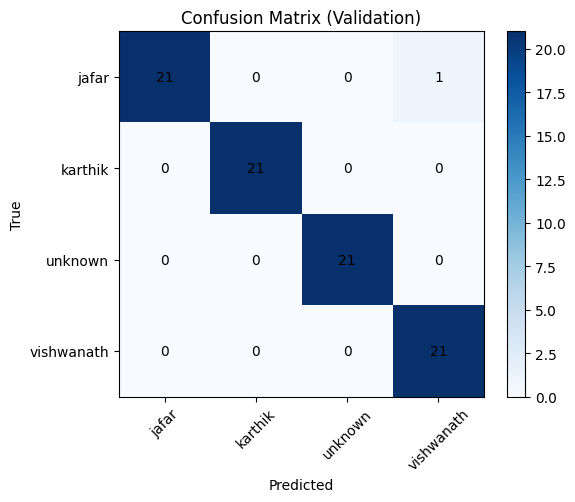

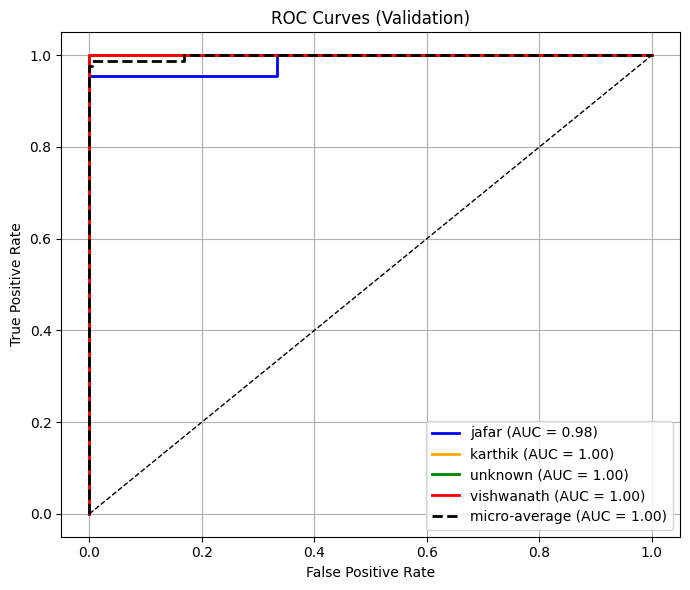


✅ Evaluation plots saved to: C:\Users\vishw\OneDrive\Desktop\deep_learning\facenet_artifacts


In [62]:
# ===============================================================
# 📊 EVALUATION: Accuracy, Confusion Matrix, ROC Curves
# ===============================================================
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    roc_curve, auc, RocCurveDisplay
)
import matplotlib.pyplot as plt
from itertools import cycle

# -------- Predictions --------
y_hat_tr = clf.predict(X_tr)
y_hat_va = clf.predict(X_va)
y_prob_va = clf.predict_proba(X_va) if hasattr(clf, "predict_proba") else None

# -------- Reports --------
print("\n=== Train ===")
print(classification_report(y_tr, y_hat_tr, target_names=le.classes_))
print("Train acc:", accuracy_score(y_tr, y_hat_tr))

print("\n=== Validation ===")
print(classification_report(y_va, y_hat_va, target_names=le.classes_))
print("Val acc:", accuracy_score(y_va, y_hat_va))

# -------- Confusion Matrix --------
cm = confusion_matrix(y_va, y_hat_va)
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Validation)")
plt.colorbar()
plt.xticks(np.arange(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(np.arange(len(le.classes_)), le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="black")

plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix.png"))
plt.show()

# -------- ROC Curve --------
if y_prob_va is not None:
    y_true_bin = np.zeros((len(y_va), len(le.classes_)))
    for i, y in enumerate(y_va):
        y_true_bin[i, y] = 1

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob_va[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average ROC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob_va.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(7,6))
    colors = cycle(["blue", "orange", "green", "red", "purple", "brown", "pink", "gray"])
    for i, color in zip(range(len(le.classes_)), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot(fpr["micro"], tpr["micro"], color="black", linestyle="--",
             label=f"micro-average (AUC = {roc_auc['micro']:.2f})", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Validation)")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "roc_curves.png"))
    plt.show()

print("\n✅ Evaluation plots saved to:", OUT_DIR)
